In [ ]:
# !pip install path/to/your/dist/flexynesis_mps-1.0.0-py3-none-any.whl

import os
import flexynesis
import torch
torch.set_num_threads(4)

Processing /Users/hc/Documents/flx/flexmpstest/dist/flexynesis_mps-1.0.0-py3-none-any.whl
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached pandas-2.3.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached lightning-2.5.3-py3-none-any.whl.metadata (39 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached torch-2.8.0-cp39-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached rich-1

/Users/hc/Documents/flx/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Seed set to 42


In [3]:
import torch; print('MPS available:', torch.backends.mps.is_available())

MPS available: True


In [4]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 2 # number of HPO iterations for final modeling run

# Modeling Breast Cancer Subtypes 

Here, we demonstrate the capabilities of `flexynesis` on a multi-omic dataset of Breast Cancer samples from the [METABRIC consortium](https://www.cbioportal.org/study/summary?id=brca_metabric). The data was downloaded from [Cbioportal](https://www.cbioportal.org/study/summary?id=brca_metabric) and randomly split into `train` (70% of the samples) and `test` (30% of the samples) data folders. The data files were processed to follow the same nomenclature. 

- `gex.csv` contains "gene expression" data
- `cna.csv` contains "copy number alteration" data
- `mut.csv` contains "mutation" data, which is a binary matrix of genes versus samples. 
- `clin.csv` contains "clinical/sample metatada", which is a table of clinical parameters such as age, gender, therapy, subtypes. 

## Data Download

The data can be downloaded as follows:

In [5]:
if not os.path.exists("brca_metabric_processed"):
    !curl -o brca_metabric.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/brca_metabric_processed.tgz" && tar -xzvf brca_metabric.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  388M  100  388M    0     0  3982k      0  0:01:39  0:01:39 --:--:-- 5037k  0:01:22 4702k  0:01:16 4115k17  0:01:14 4003k 0:01:13 4041k:01:38  0:00:33  0:01:05 2943k 0  0:01:48  0:00:47  0:01:01 3132k
x brca_metabric_processed/
x brca_metabric_processed/test/
x brca_metabric_processed/test/gex.csv
x brca_metabric_processed/test/mut.csv
x brca_metabric_processed/test/clin.csv
x brca_metabric_processed/test/cna.csv
x brca_metabric_processed/9606.protein.aliases.v12.0.txt.gz
x brca_metabric_processed/9606.protein.links.v12.0.txt.gz
x brca_metabric_processed/train/
x brca_metabric_processed/train/gex.csv
x brca_metabric_processed/train/mut.csv
x brca_metabric_processed/train/clin.csv
x brca_metabric_processed/train/cna.csv


In [6]:
data_importer = flexynesis.DataImporter(path ='./brca_metabric_processed', 
                                        data_types = ['gex', 'cna'], 
                                        concatenate=False, 
                                        top_percentile=10, 
                                        min_features=100, 
                                        variance_threshold=0.8, # set to 0.8 for 80%   
                                       )
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/train/cna.csv...
[INFO] Importing ./brca_metabric_processed/train/gex.csv...
[INFO] Importing ./brca_metabric_processed/train/clin.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/test/cna.csv...
[INFO] Importing ./brca_metabric_processed/test/gex.csv...
[INFO] Importing ./brca_metabric_processed/test/clin.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 7  # of rows: 5
[INFO] Number of NA value

Filtering redundant features: 100%|██████████| 412/412 [00:00<00:00, 7180.30it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  4509 features  and  1303  samples 


Filtering redundant features: 100%|██████████| 450/450 [00:00<00:00, 270910.98it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 16482 features.

[INFO] working on layer:  cna
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 63  # of rows: 51
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 18033 features.
[INFO] DataFrame gex - Removed 2 samples (0.36%).
[INFO] DataFrame cna - Removed 2 samples (0.36%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: gex': 408, 'feature_count in: cna': 450, 'sample_count': 1303}
[INFO] Test Data Stats:  {'feature_count in: gex': 408, 'feature_count in: cna': 4

- **dataset.dat** contains the data matrices

In [4]:
train_dataset.dat

{'gex': tensor([[ 0.6745,  0.3363,  0.7912,  ..., -0.1381, -0.1925, -0.5064],
         [ 0.6311,  1.0591,  1.1127,  ...,  0.3443,  0.2635, -0.0371],
         [-2.9105, -2.6855, -1.8729,  ...,  0.7141,  0.4693,  0.6399],
         ...,
         [ 0.2094, -0.9346,  0.5955,  ...,  1.7482,  0.8156,  0.5763],
         [-2.3077, -2.4668, -1.5716,  ...,  0.9599,  1.1496,  1.3106],
         [ 0.3417,  0.5987,  0.9377,  ..., -0.1620, -0.4805, -0.7580]]),
 'cna': tensor([[-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         [ 0.2908,  0.2509,  0.2583,  ...,  0.2730,  0.2473,  0.2537],
         [-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         ...,
         [-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         [ 0.2908,  0.2509,  0.2583,  ..., -1.0112, -1.0365,  0.2537],
         [ 0.2908,  1.5381,  1.5378,  ...,  0.2730,  0.2473,  1.5447]])}

In [5]:
train_dataset.dat['gex'].shape, train_dataset.dat['cna'].shape

(torch.Size([1303, 408]), torch.Size([1303, 450]))

- dataset.ann contains the sample annotation data (from clin.csv), where the keys are variable names and values are tensors. 


In [6]:
train_dataset.ann

{'LYMPH_NODES_EXAMINED_POSITIVE': tensor([0, 0, 2,  ..., 0, 0, 2]),
 'NPI': tensor([2.0520, 3.0800, 5.0800,  ..., 3.1000, 4.0920, 5.1600]),
 'AGE_AT_DIAGNOSIS': tensor([57.7500, 71.6700, 53.3500,  ..., 39.9200, 60.6000, 78.8700]),
 'OS_MONTHS': tensor([229.8333,  43.9000,  16.7000,  ...,  73.4667, 255.6000,  42.5000]),
 'RFS_MONTHS': tensor([226.8100,  24.0500,   4.9700,  ...,  53.0600, 252.2400,  22.0400]),
 'CELLULARITY': tensor([2., 2., 0.,  ..., 2., 2., 0.]),
 'CHEMOTHERAPY': tensor([0., 0., 1.,  ..., 0., 0., 0.]),
 'COHORT': tensor([2., 2., 2.,  ..., 2., 4., 2.]),
 'ER_IHC': tensor([1., nan, 0.,  ..., 1., 0., 1.]),
 'HER2_SNP6': tensor([2., 2., 2.,  ..., 2., 2., 2.]),
 'HORMONE_THERAPY': tensor([1., 0., 1.,  ..., 0., 0., 1.]),
 'INFERRED_MENOPAUSAL_STATE': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'SEX': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'INTCLUST': tensor([ 2.,  9.,  1.,  ...,  4., 10.,  0.]),
 'OS_STATUS': tensor([0., 1., 1.,  ..., 1., 0., 1.]),
 'CLAUDIN_SUBTYPE': tensor(

- A mapping of the sample labels for categorical variables can be found in dataset.label_mappings

In [7]:
train_dataset.label_mappings

{'CELLULARITY': {0: 'High', 1: 'Low', 2: 'Moderate', 3: nan},
 'CHEMOTHERAPY': {0: 'NO', 1: 'YES'},
 'COHORT': {0: 'cohort1',
  1: 'cohort2',
  2: 'cohort3',
  3: 'cohort4',
  4: 'cohort5'},
 'ER_IHC': {0: 'Negative', 1: 'Positve', 2: nan},
 'HER2_SNP6': {0: 'GAIN', 1: 'LOSS', 2: 'NEUTRAL', 3: 'UNDEF'},
 'HORMONE_THERAPY': {0: 'NO', 1: 'YES'},
 'INFERRED_MENOPAUSAL_STATE': {0: 'Post', 1: 'Pre'},
 'SEX': {0: 'Female'},
 'INTCLUST': {0: '1',
  1: '10',
  2: '2',
  3: '3',
  4: '4ER+',
  5: '4ER-',
  6: '5',
  7: '6',
  8: '7',
  9: '8',
  10: '9'},
 'OS_STATUS': {0: '0:LIVING', 1: '1:DECEASED'},
 'CLAUDIN_SUBTYPE': {0: 'Basal',
  1: 'Her2',
  2: 'LumA',
  3: 'LumB',
  4: 'NC',
  5: 'Normal',
  6: 'claudin-low'},
 'THREEGENE': {0: 'ER+/HER2- High Prolif',
  1: 'ER+/HER2- Low Prolif',
  2: 'ER-/HER2-',
  3: 'HER2+',
  4: nan},
 'VITAL_STATUS': {0: 'Died of Disease',
  1: 'Died of Other Causes',
  2: 'Living',
  3: nan},
 'LATERALITY': {0: 'Left', 1: 'Right', 2: nan},
 'RADIO_THERAPY': {0: 

- As the data matrices are stored as tensors, the row and column names cannot be stored as tensors. These are stored in the same dataset object as:`dataset.samples` and `dataset.features`

In [8]:
train_dataset.samples[1:10], train_dataset.features

(['MB-4802',
  'MB-5299',
  'MB-2977',
  'MB-5266',
  'MB-6254',
  'MB-4342',
  'MB-4792',
  'MB-7113',
  'MB-0906'],
 {'gex': Index(['FOXA1', 'MLPH', 'ESR1', 'GATA3', 'SPDEF', 'TBC1D9', 'FOXC1', 'C1S',
         'XBP1', 'CA12',
         ...
         'N4BP2', 'TNFSF14', 'LEP', 'INIP', 'RPL7L1', 'MBD4', 'HCG2P7', 'ZNF430',
         'KIAA1791', 'IL10'],
        dtype='object', length=408),
  'cna': Index(['DAP3', 'FCRLA', 'TOP1P1', 'LAMC1', 'TDRKH', 'MSTO2P', 'MSTO1',
         'YY1AP1', 'EFNA1', 'DPM3',
         ...
         'XPR1', 'SOAT1', 'SELENBP1', 'PI4KB', 'RFX5', 'SELP', 'AXDND1',
         'KIAA1614', 'TRMT1L', 'FMO9P'],
        dtype='object', length=450)})

- We can get a summary of sample metadata using `print_summary_stats`. For categorical variables, we can the sample counts per label and for numerical variables, we get mean/median statistics. 

In [9]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: LYMPH_NODES_EXAMINED_POSITIVE
Numerical Variable Summary: Median = 0.0, Mean = 1.9286262471220261
------
Summary for variable: NPI
Numerical Variable Summary: Median = 4.039999961853027, Mean = 4.017291069030762
------
Summary for variable: AGE_AT_DIAGNOSIS
Numerical Variable Summary: Median = 61.790000915527344, Mean = 61.30643844604492
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 114.46666717529297, Mean = 125.0357437133789
------
Summary for variable: RFS_MONTHS
Numerical Variable Summary: Median = 100.62999725341797, Mean = 109.94034576416016
------
Summary for variable: CELLULARITY
Categorical Variable Summary:
  Label: High, Count: 656
  Label: Low, Count: 136
  Label: Moderate, Count: 484
  Label: nan, Count: 27
------
Summary for variable: CHEMOTHERAPY
Categorical Variable Summary:
  Label: NO, Count: 1044
  Label: YES, Count: 259
------
Summary for variable: COHORT
Categorical Variable Summary:
  Label: cohort1, Count: 308
 

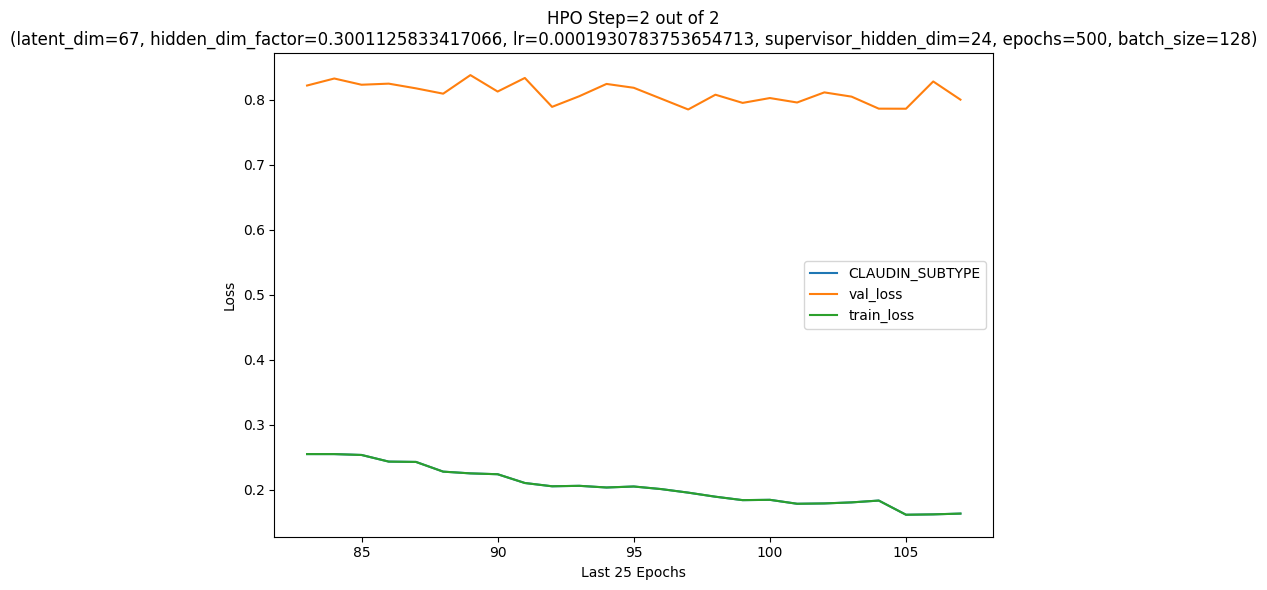

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/hc/Documents/flx/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hc/Documents/flx/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Seed set to 42
Seed set to 42


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      CLAUDIN_SUBTYPE      │    0.7998718619346619     │
│         val_loss          │    0.7998718619346619     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 2/2 [01:11<00:00, 35.94s/it, Iteration=2, Best Loss=0.8]  

[INFO] current best val loss: 0.7998718619346619; best params: {'latent_dim': 67, 'hidden_dim_factor': 0.3001125833417066, 'lr': 0.0001930783753654713, 'supervisor_hidden_dim': 24, 'epochs': 500, 'batch_size': 128} since 0 hpo iterations


In [7]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["CLAUDIN_SUBTYPE"],
                                        config_name = "DirectPred", 
                                        n_iter=HPO_ITER, plot_losses=True,
                                        early_stop_patience=10)
model, best_params = tuner.perform_tuning()

In [11]:
model

DirectPred(
  (log_vars): ParameterDict(  (CLAUDIN_SUBTYPE): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=408, out_features=104, bias=True)
      (layer_out): Linear(in_features=104, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=450, out_features=114, bias=True)
      (layer_out): Linear(in_features=114, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(114, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fusion_block): Linear(in_features=210, out_features=105, bias=True)
  (MLPs): ModuleDict(
    (CLAUDIN_SUBTYPE): MLP(
      (layer_1): Linear(in_features=105, out_features=22, bias=True)
      

In [12]:
best_params

{'latent_dim': 105,
 'hidden_dim_factor': 0.25503043695984917,
 'lr': 0.00362561763457623,
 'supervisor_hidden_dim': 22,
 'epochs': 20,
 'batch_size': 32}

### Prediction and Model Evaluation

We can use the best model (chosen based on the hyperparameter optimisation procedure) to make predictions on the test dataset

In [13]:
y_pred_dict = model.predict(test_dataset)

In [14]:
y_pred_dict

{'CLAUDIN_SUBTYPE': array([[8.70832875e-02, 3.15561175e-01, 2.44200751e-01, ...,
         4.52635251e-02, 1.21889114e-01, 1.65273566e-02],
        [1.28731379e-04, 2.39293999e-03, 9.14055705e-01, ...,
         2.85849371e-03, 5.73413819e-03, 4.32075147e-04],
        [2.29501631e-03, 9.23628986e-01, 3.86650935e-02, ...,
         1.01850592e-02, 1.03442175e-02, 4.44716832e-04],
        ...,
        [1.63640723e-01, 1.97159732e-03, 1.91206615e-02, ...,
         2.27338634e-03, 8.64143446e-02, 7.21255362e-01],
        [7.31631502e-08, 1.59608146e-06, 9.95277643e-01, ...,
         6.26905457e-05, 1.15736593e-05, 5.66737071e-06],
        [4.00564726e-03, 5.00613332e-01, 2.65559405e-01, ...,
         2.62357350e-02, 8.81381109e-02, 7.82470498e-03]], dtype=float32)}

- The predictions are class labels for both variables. Now, we can run `evaluate_wrapper` to evaluate all predictions. 
The wrapper goes through each variable and figures out which type of evaluation to apply to the corresponding variable (whether to report metrics relevant to regression tasks or classification tasks) 

In [15]:
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)
metrics_df

,method,var,variable_type,metric,value
0,DirectPred,CLAUDIN_SUBTYPE,categorical,balanced_acc,0.594643
1,DirectPred,CLAUDIN_SUBTYPE,categorical,f1_score,0.738534
2,DirectPred,CLAUDIN_SUBTYPE,categorical,kappa,0.664230
3,DirectPred,CLAUDIN_SUBTYPE,categorical,average_auroc,0.940336
4,DirectPred,CLAUDIN_SUBTYPE,categorical,average_aupr,0.819682


### Extracting the sample embeddings

All models trained within `flexynesis` comes with a `transform` method, which extracts the sample embeddings that are generated by the encoding networks (whether it is an MLP or a variational autoencoder). The embeddings reflect a merged representation of multiple omic layers. 

In [16]:
ds = test_dataset
E = model.transform(ds)

In [17]:
E.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E95,E96,E97,E98,E99,E100,E101,E102,E103,E104
MB-5045,-0.167397,-1.131019,0.378562,-0.900014,-2.524680,3.555223,-2.066664,-1.098777,-0.683311,0.245331,...,-4.604910,0.494096,-0.031380,1.504522,0.369521,-1.222306,-0.157002,0.093301,-1.061750,3.007037
MB-5384,0.923127,0.082788,0.671110,-0.994307,-0.035396,2.274185,-2.683631,0.845280,-0.025693,0.154437,...,-1.453277,2.208455,1.549480,0.334104,0.410448,-1.317116,0.100894,1.281775,1.241873,1.187484
MB-4323,2.202557,-4.409516,4.623548,0.811854,4.245316,-0.790349,2.293735,-2.717519,1.556471,-6.244445,...,-1.244949,-5.053821,-5.419843,3.317890,-3.995125,5.007565,0.084106,-1.095302,-6.155218,-1.745264
MB-2744,-5.685959,5.922356,-5.336407,3.703537,-0.595856,13.460025,3.064089,13.099288,7.689935,7.012273,...,-3.373737,-0.756873,4.383973,-4.093043,13.376520,-4.777242,7.054605,6.700991,5.207217,11.695190
MB-6145,-0.756231,-1.404978,-1.238429,-1.810342,-0.012434,-3.783204,-1.129133,-4.469532,-4.363313,1.301490,...,-1.246370,-1.908770,-3.807631,-0.906491,-2.838399,1.826792,-3.410417,0.176685,-4.978497,-1.234893


### Visualizing the sample embeddings

Let's visualize the embeddings in a reduced space and color by the target variables. 

In [18]:
f = 'CLAUDIN_SUBTYPE'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

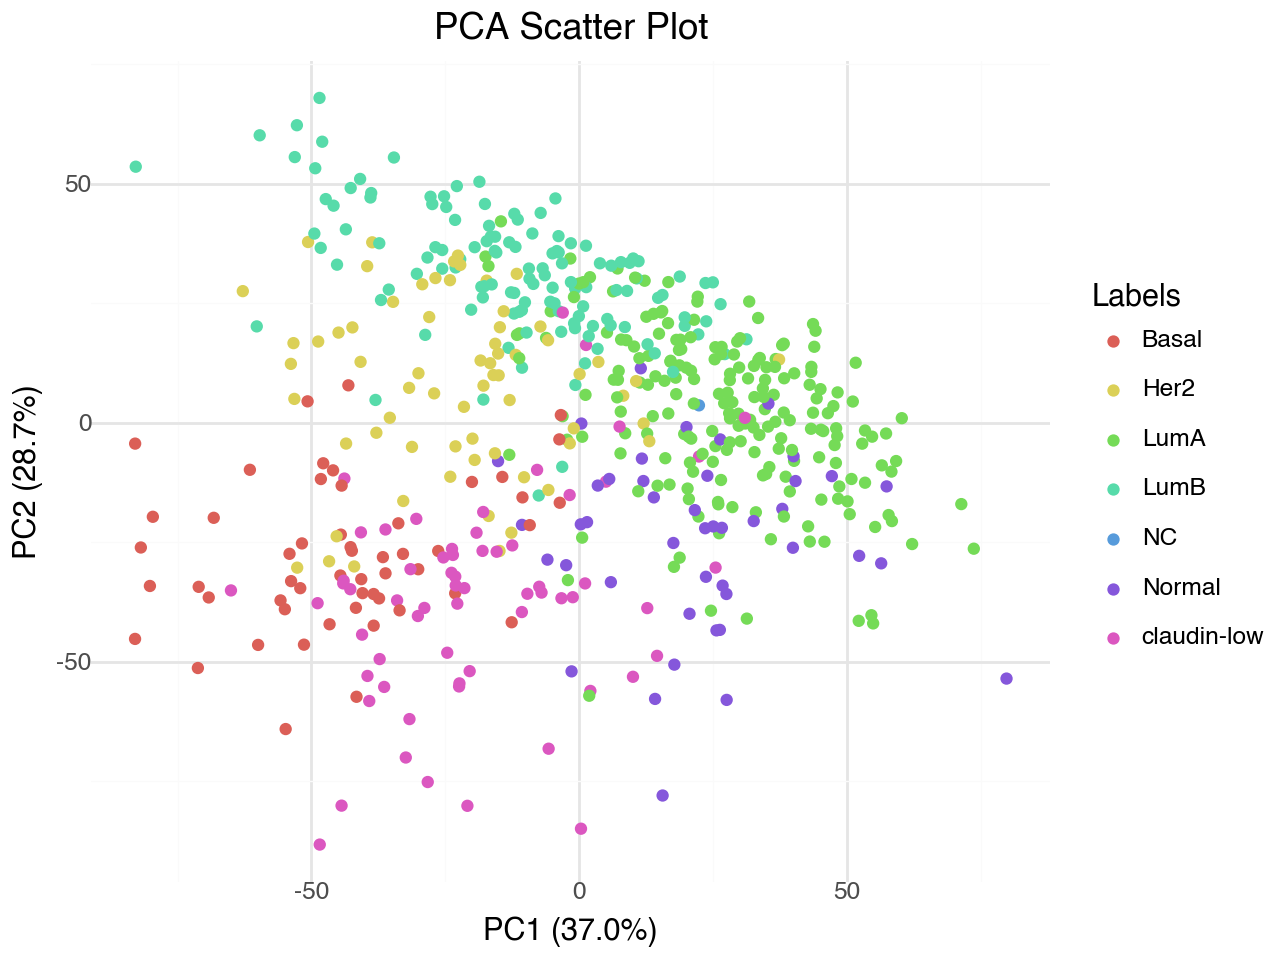

In [19]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='pca')

We can also use UMAP visualisation

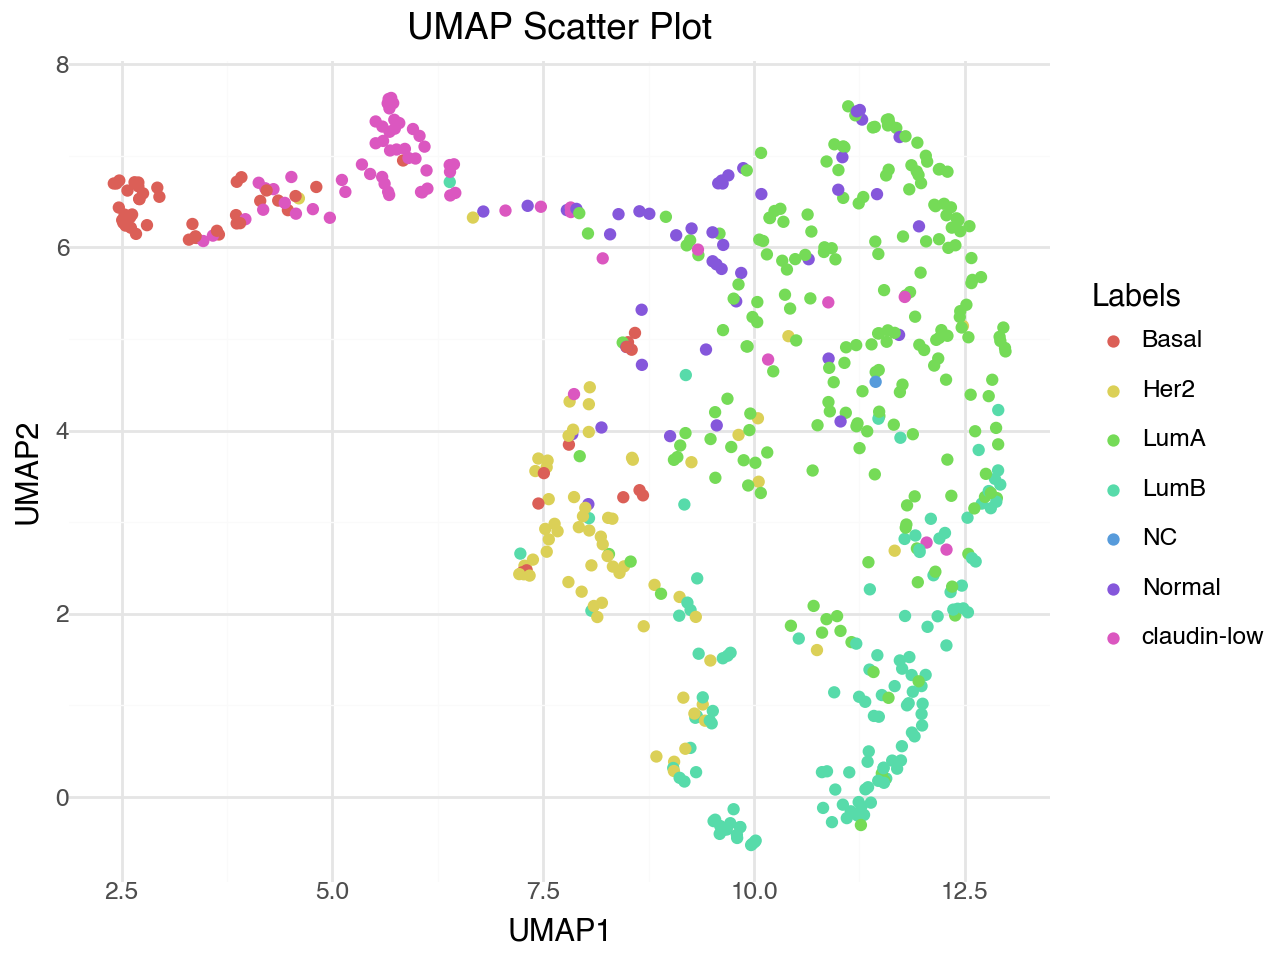

In [20]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')